### **Python Analysis of Longitudinal Alzheimer's Dementia (OASIS-2)** 

#### **Importing pandas, matlab, seaborn, scipy**

In [56]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

#### **Reading data**

In [5]:
df = pd.read_csv("/workspaces/235003126/MRI/mri_longitudinal.csv")

In [ ]:
df.head()

In [ ]:
df.tail()

In [7]:
#row and column count
df.shape

(373, 15)

In [8]:
#in depth overlook
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB


In [ ]:
#null count by column
df.isnull().sum()



In [ ]:
#looking at subject with nulls in MMSE column
df[df["MMSE"].isna()]

In [ ]:
#looking at subject with nulls in SES column
df[df["SES"].isna()]

In [13]:
#statistical summary
df.describe()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,373.000000,373.000000,354.000000,371.000000,373.000000,373.000000,373.000000,373.000000
mean,1.882038,595.104558,77.013405,14.597855,2.460452,27.342318,0.290885,1488.128686,0.729568,1.195461
std,0.922843,635.485118,7.640957,2.876339,1.134005,3.683244,0.374557,176.139286,0.037135,0.138092
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000
50%,2.000000,552.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000
75%,2.000000,873.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


In [ ]:
#look closely at statistics of column CDR
df['CDR'].nunique(), df.groupby('CDR').size().describe()

(4,
 count      4.000000
 mean      93.250000
 std       90.319341
 min        3.000000
 25%       31.500000
 50%       82.000000
 75%      143.750000
 max      206.000000
 dtype: float64)

In [ ]:
#look closely at statistics of column MMSE
print(df['MMSE'].describe())

count    371.000000
mean      27.342318
std        3.683244
min        4.000000
25%       27.000000
50%       29.000000
75%       30.000000
max       30.000000
Name: MMSE, dtype: float64


In [14]:
#to see how many unique subjects and how many visits per subject and stats about visits per subject
df['Subject ID'].nunique(), df.groupby('Subject ID').size().describe()

(150,
 count    150.000000
 mean       2.486667
 std        0.730327
 min        2.000000
 25%        2.000000
 50%        2.000000
 75%        3.000000
 max        5.000000
 dtype: float64)

#### **Transforming and preparing data**

There were nulls for SES and MMSE. Since R analysis demonstrated the importance of MMSE over SES for AD, we are focused on MMSE. Therefore, plan to replace null MMSEs. 

In [ ]:
#obtain stats of MMSE for CDR = 1
print(df.groupby('CDR')['MMSE'].describe())

In [ ]:
#obtain median of MMSE for CDR = 1 to replace null MMSE
print(df.groupby('CDR')['MMSE'].median())

In [ ]:
#median for this can also be obtained by:
median_mmse_cdr1 = df.loc[df['CDR'] == 1, 'MMSE'].median()
print(median_mmse_cdr1)

There were 2 null MMSEs for moderately demented subject CDR=1. Given small sample size and 2 outliers for CDR=1 (see pair plot below), plan to replace missing values with median MMSE for CDR=1. 

In [ ]:
#replace null MMSE with median
df.fillna({'MMSE': median_mmse_cdr1}, inplace=True)

In [ ]:
#ensuring that nulls were replaced
df.loc[df['CDR'] == 1]

We need to standardize time and date between MRI scans using MR Delay. To accomodate for errors, coerce to NaT. Create scan_date 

In [ ]:
#create scan_date, standardizing datetime format
df['scan_date'] = pd.to_datetime(df['MR Delay'], errors='coerce')

In [ ]:
#creating column of years from first MRI
df.sort_values(['Subject ID', 'Visit'])
df['baseline_age'] = df.groupby('Subject ID')['Age'].transform('first')
df['years_from_baseline'] = df['Age'] - df['baseline_age']

#showing years from baseline
df[['Subject ID', 'Visit', 'Age', 'years_from_baseline', 'MMSE', 'nWBV']].head(20)

#### **Exploratory Data Analysis (EDA)**

Examining relationships and outliers using pair plots. There are 2 outliers for MMSE for subjects with moderate disease. Poor cognition is a symptom of AD. Although cognition was found clinically much worse compared other moderately demented subjects, this is expected for progressing disease. 

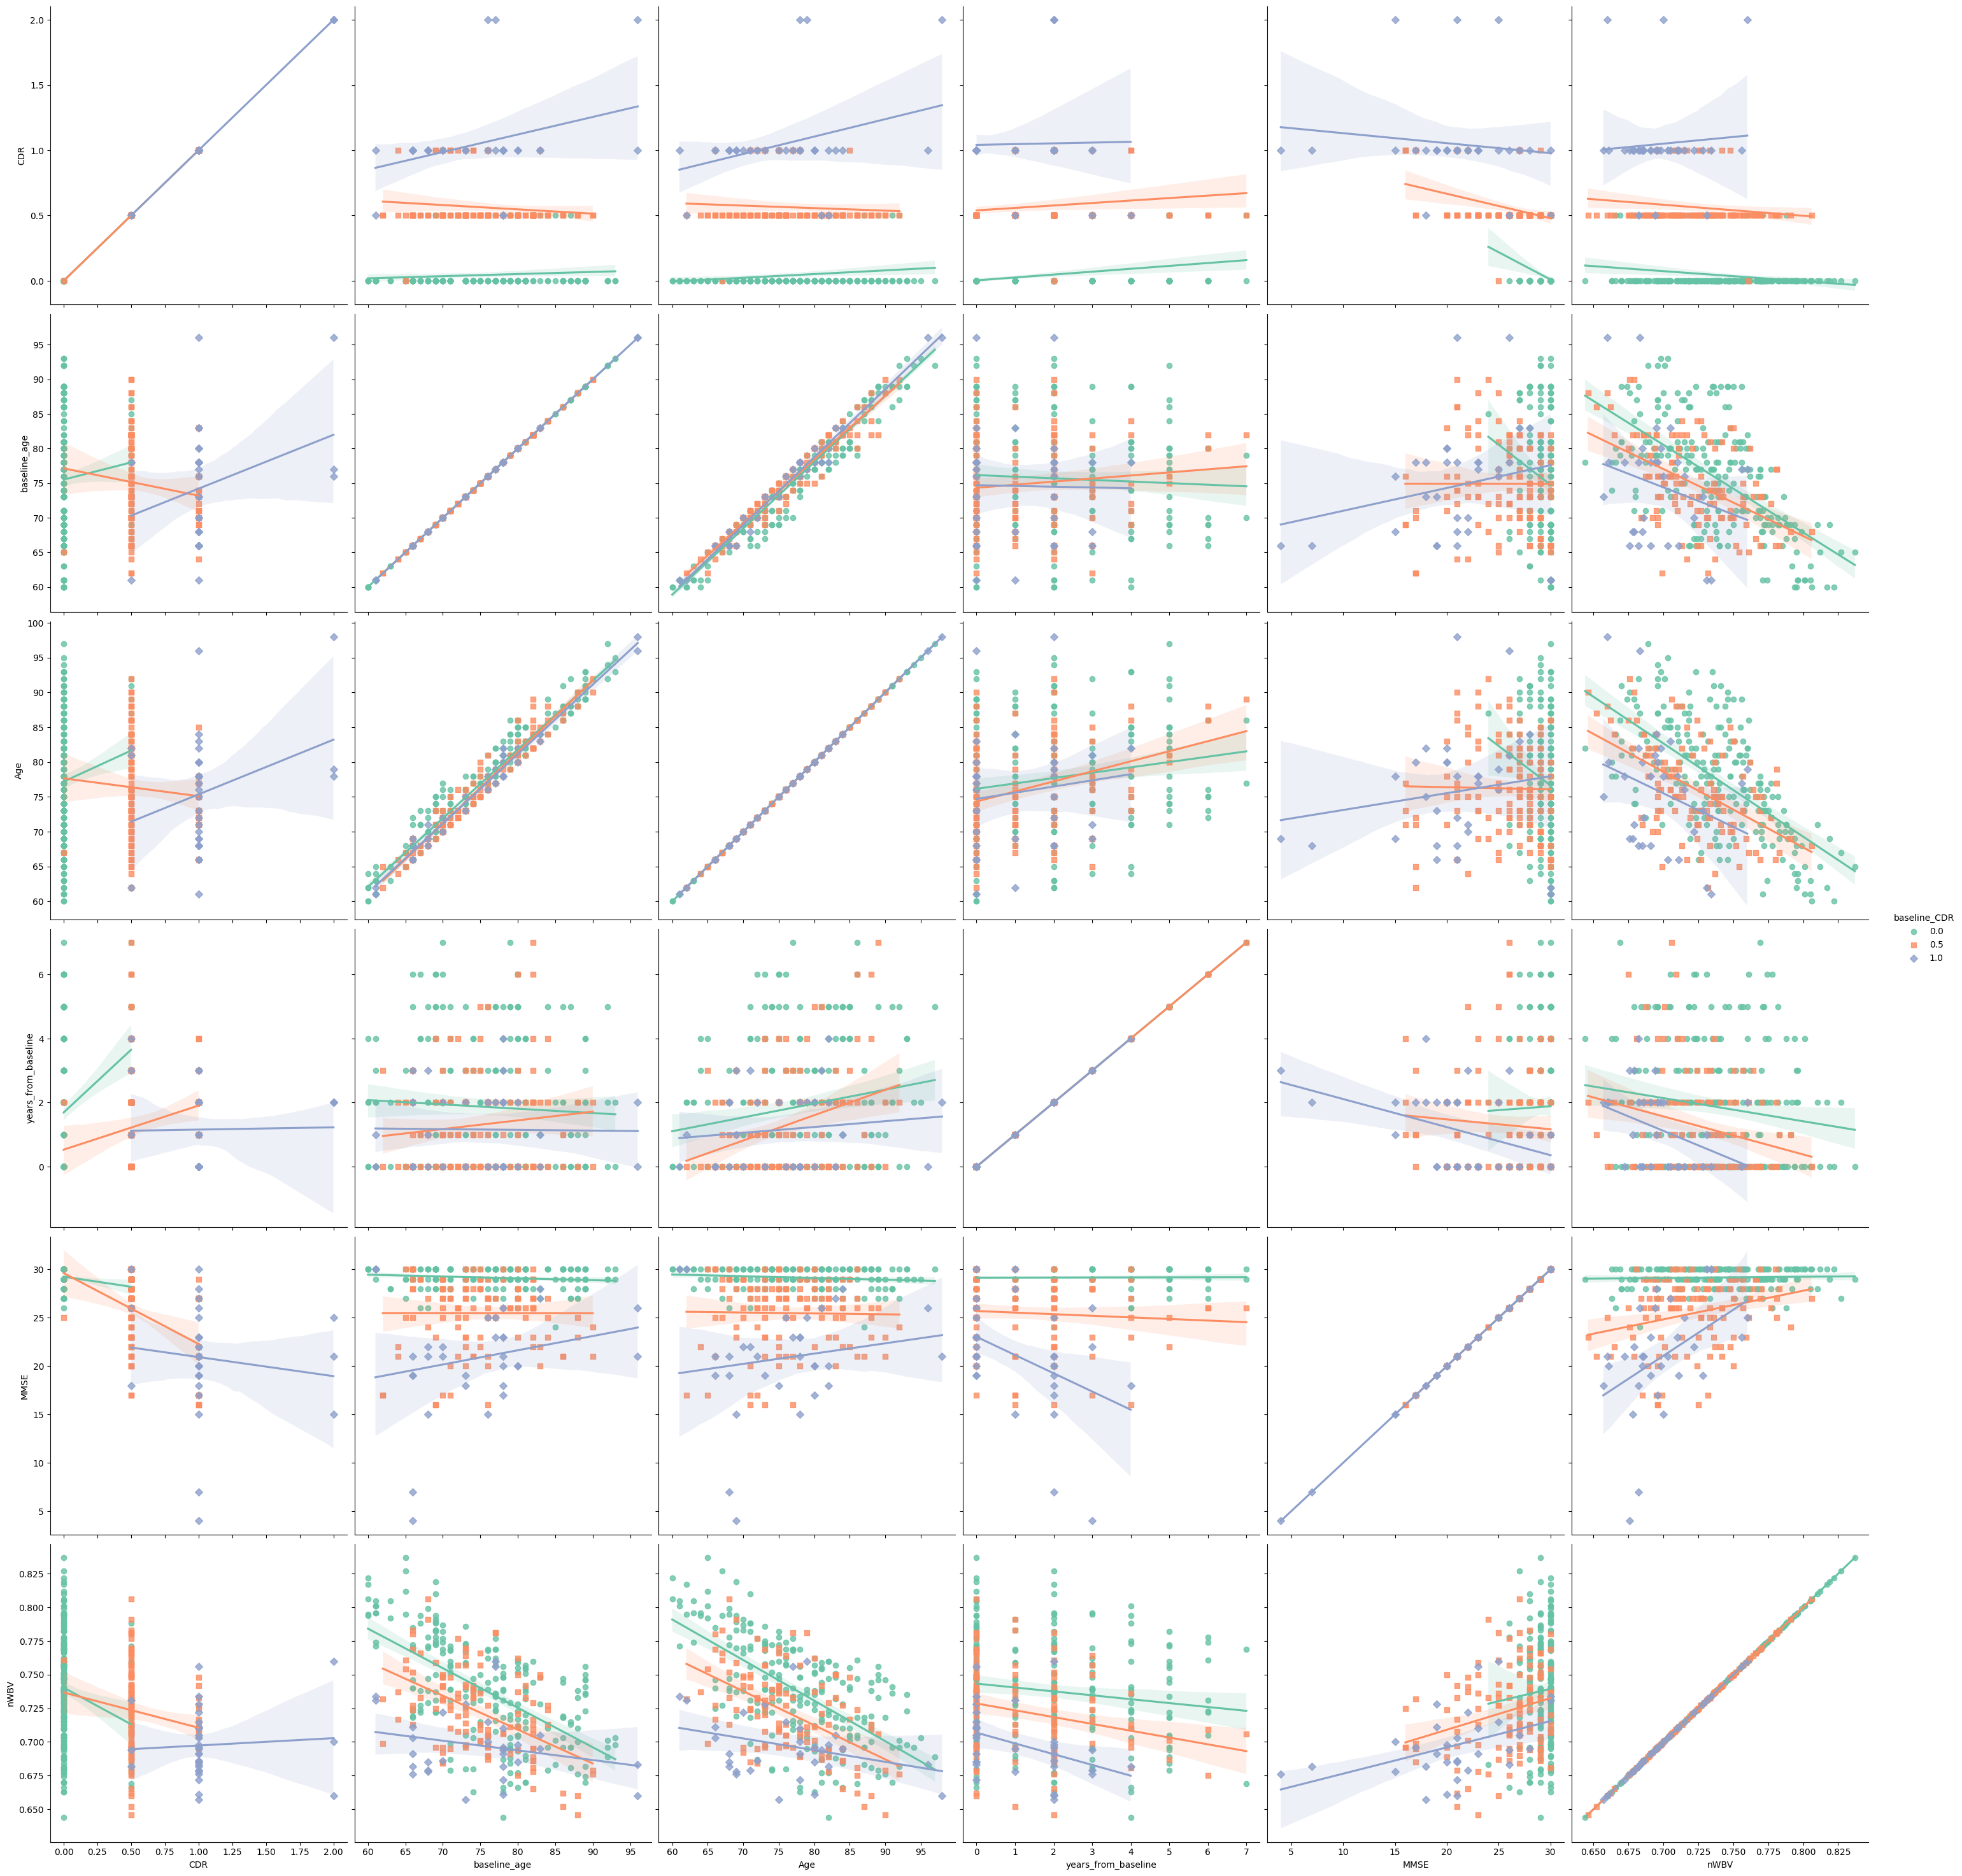

In [91]:
#pair plot with regression line
df = df.sort_values(['Subject ID', 'Visit'])
df['baseline_CDR'] = df.groupby('Subject ID')['CDR'].transform('first')

unique_groups = sorted(df['baseline_CDR'].unique())


g = sns.pairplot(
    df,
    x_vars=["CDR", "baseline_age", "Age", "years_from_baseline", "MMSE", "nWBV"],
    y_vars=["CDR", "baseline_age", "Age", "years_from_baseline", "MMSE", "nWBV"],
    kind='reg', hue='baseline_CDR', diag_kind = None, markers=["o", "s", "D"], palette="Set2", height=5)
plt.show()

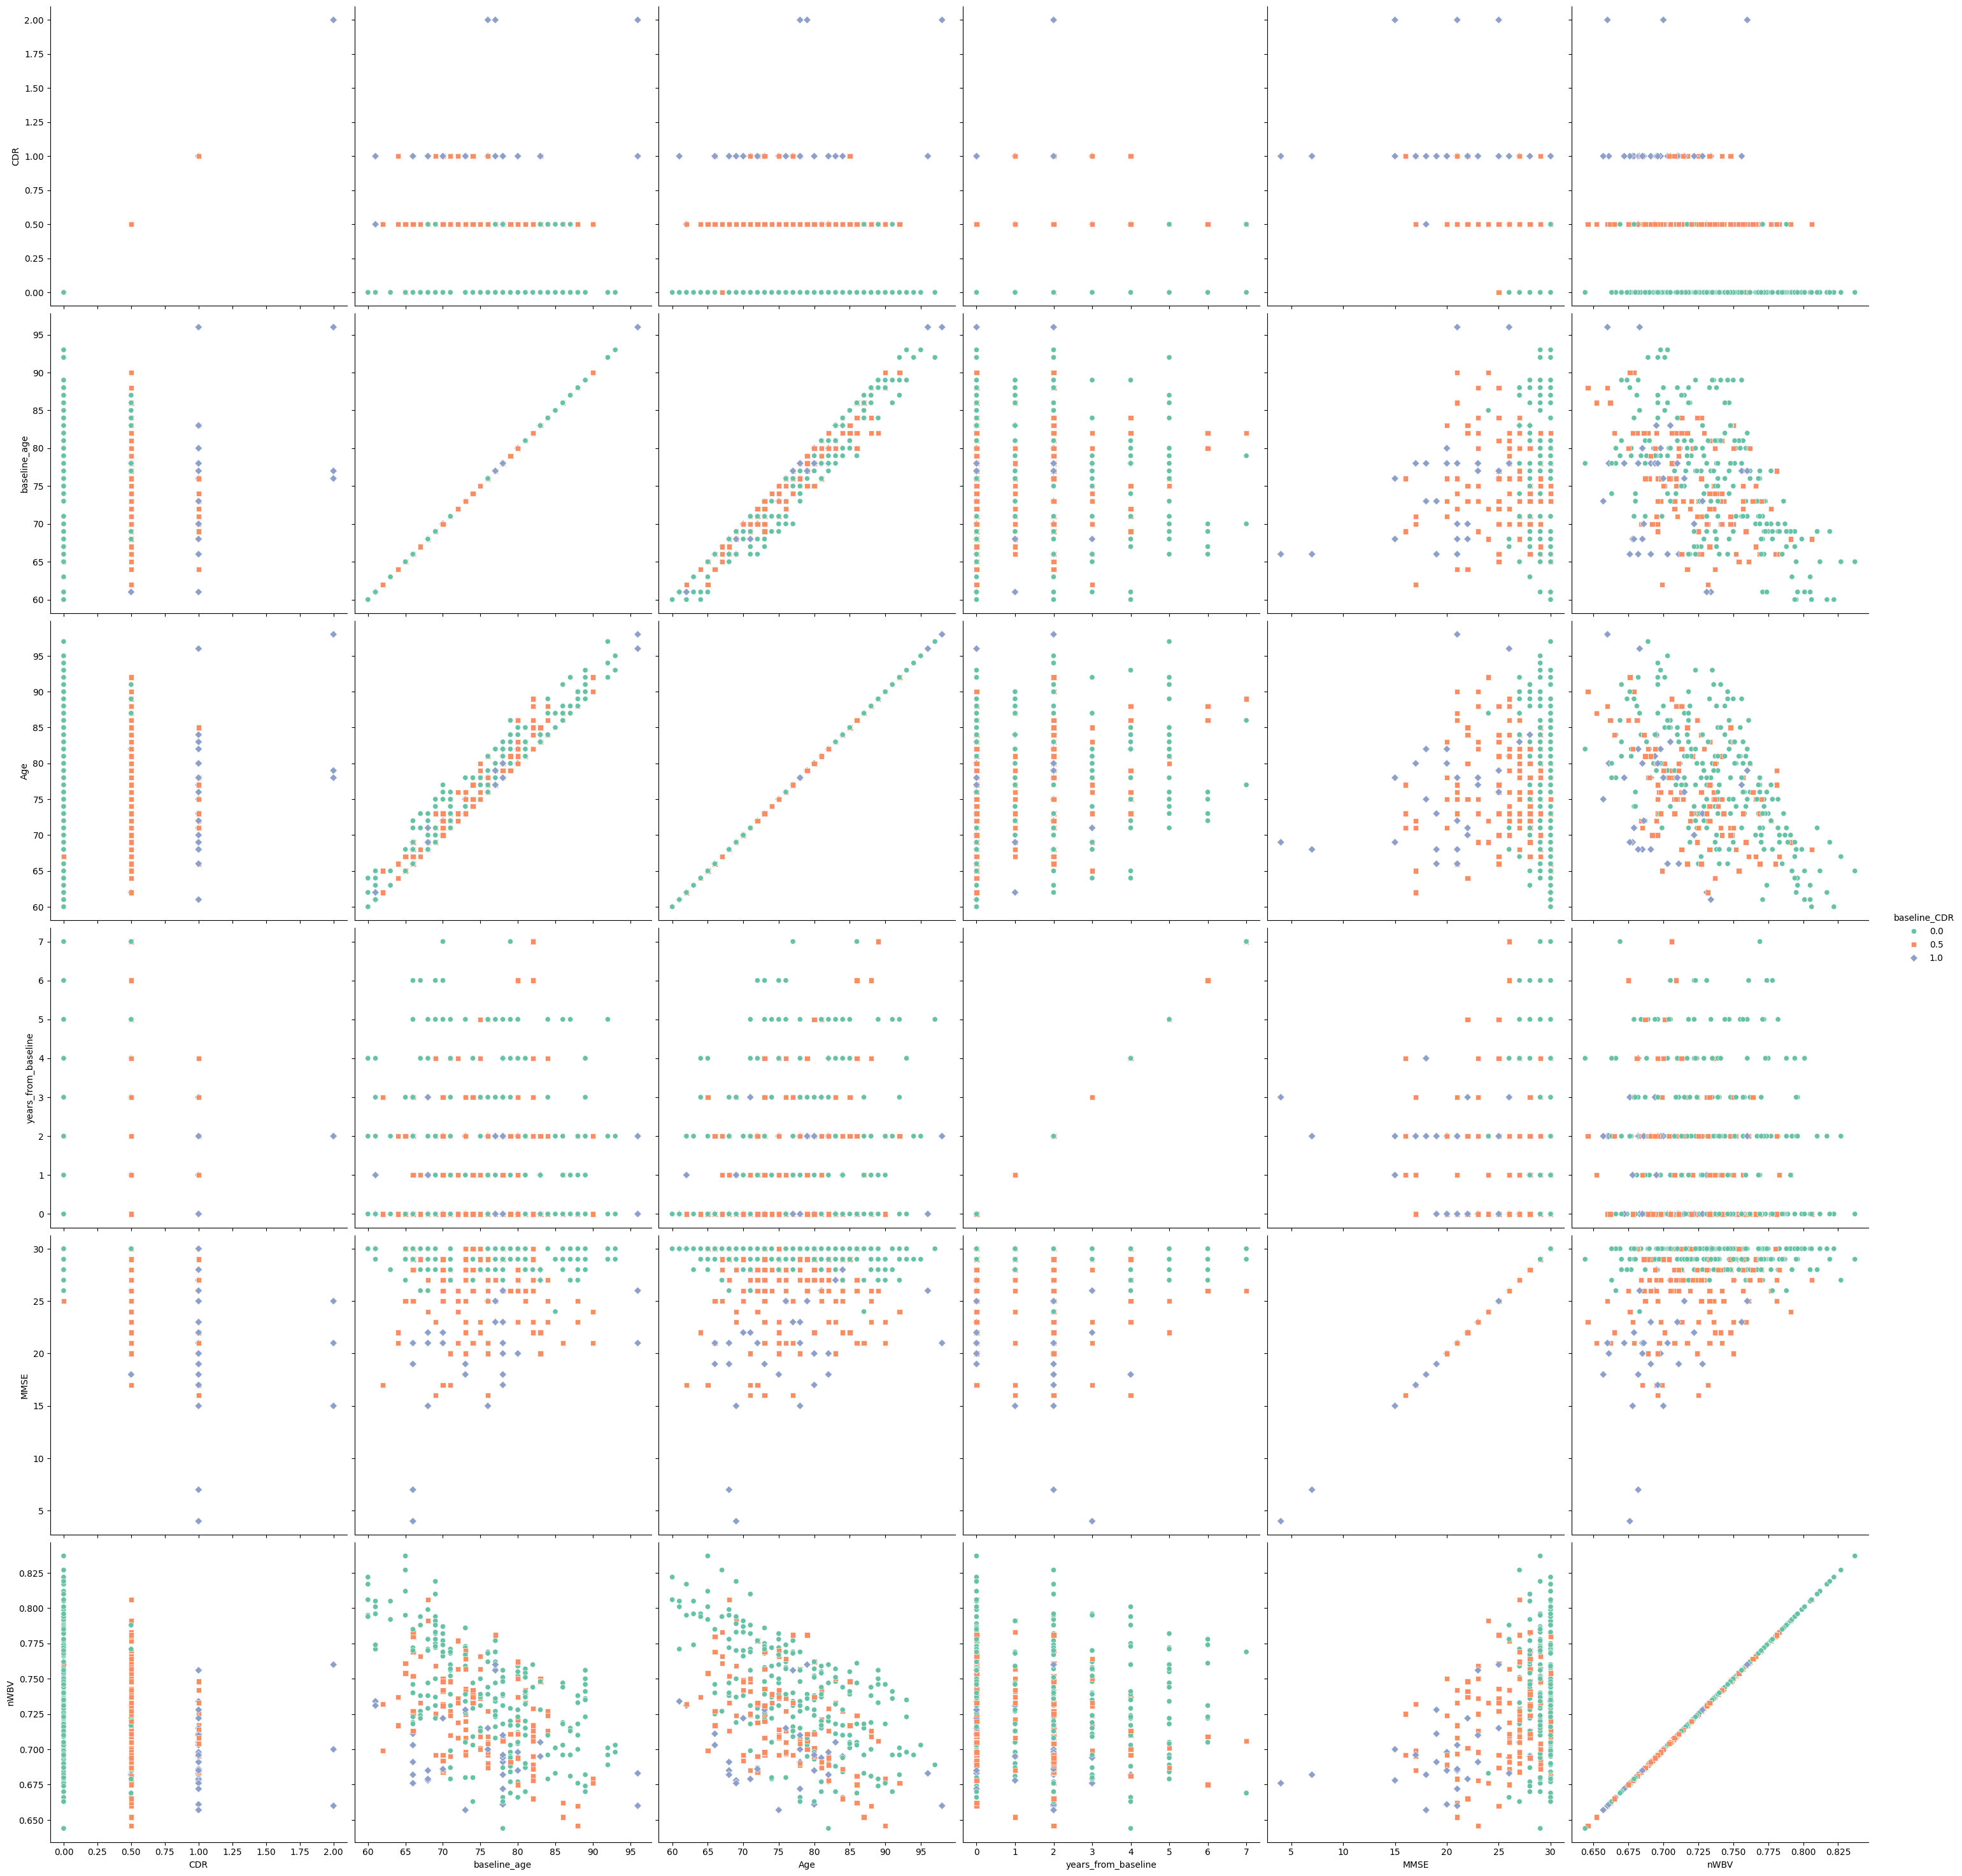

In [ ]:
#pair plot without regression
df = df.sort_values(['Subject ID', 'Visit'])
df['baseline_CDR'] = df.groupby('Subject ID')['CDR'].transform('first')

unique_groups = sorted(df['baseline_CDR'].unique())


g = sns.pairplot(
    df,
    x_vars=["CDR", "baseline_age", "Age", "years_from_baseline", "MMSE", "nWBV"],
    y_vars=["CDR", "baseline_age", "Age", "years_from_baseline", "MMSE", "nWBV"],
     hue='baseline_CDR', diag_kind = None, markers=["o", "s", "D"], palette="Set2", height=5)
plt.show()